# LightGB Model for Google Analytics Challenge

In [43]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Import csv's
df_train = pd.read_csv(r"C:\Google Analytics Customer Revenue Prediction\train-flattened.csv"
                       ,dtype={'fullVisitorId': 'str','totals.transactionRevenue':'float'}, header=0)

df_test= pd.read_csv(r"C:\Google Analytics Customer Revenue Prediction\test-flattened.csv"
                     ,dtype={'fullVisitorId': 'str'},header=0)

In [45]:
# Lets Explore the variables
df_train.columns
print('Is there more than one transaction by VisitorId?',
      len(df_train['fullVisitorId'])!=df_train['fullVisitorId'].nunique())
print('\nNumber of unique visitors in train set:'
      ,df_train['fullVisitorId'].nunique(),'out of',len(df_train))
print('\nNumber of unique visitors in test set:'
      ,df_test['fullVisitorId'].nunique(),'out of',len(df_test))

Is there more than one transaction by VisitorId? True

Number of unique visitors in train set: 714167 out of 903653

Number of unique visitors in test set: 617242 out of 804684


In [46]:
# Drop Different Columns from train and test
print('\nIs there different columns from train and test?:',
      df_train.drop('totals.transactionRevenue',axis=1).columns.tolist()==df_test.columns.tolist())
print("Variables not in test but in train : ", 
      set(df_train.drop('totals.transactionRevenue',axis=1).columns).difference(set(df_test.columns)))
dif = list(set(df_train.drop('totals.transactionRevenue',axis=1).columns).difference(set(df_test.columns)))
df_train.drop(dif,axis=1,inplace=True)


Is there different columns from train and test?: False
Variables not in test but in train :  {'trafficSource.campaignCode'}


In [47]:
# Columns with constant values
dropcols_train = [c for c in df_train.columns if (df_train[c].nunique()==1) & (df_train[c].isnull().sum() == 0)]
dropcols_test = [c for c in df_test.columns if (df_test[c].nunique()==1) & (df_test[c].isnull().sum() == 0)]
cols_to_drop = list(set(dropcols_train+dropcols_test))

### Feature Engineering

In [48]:
# Verify is features in both train and test datasets are equal:
print('Train and Test have any different features?',
      False in df_train.drop('totals.transactionRevenue',axis=1).columns == df_test.columns)

Train and Test have any different features? False


So, apart from the target values, there are no features difference between these datasets.The 'sessionId' and 'visitId' features are not going to be usefull for us, so we can drop it.

In [49]:
cols_to_drop = list(set(cols_to_drop + ['sessionId','visitId']))

In [50]:
# Store and Drops Id's from datasets, and Target from Train Dataset
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].astype(float)
df_train["totals.transactionRevenue"].fillna(0, inplace=True)# Impute 0 for missing target values
y_train = df_train["totals.transactionRevenue"].values
train_id = df_train["fullVisitorId"].values
pred_id = df_test["fullVisitorId"].values

In [51]:
# In[6]: Feature Engineering:
def process_date_time(data_df):
    print("process date time ...")
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    data_df['weekofyear'] = data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    data_df['weekofyear_unique_user_count'] = data_df.groupby('weekofyear')['fullVisitorId'].transform('nunique')
    return data_df

def process_device(data_df):
    print("process device ...")
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.operatingSystem'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    return data_df

def process_totals(data_df):
    print("process totals ...")
#    data_df['visitNumber'] = np.log1p(data_df['visitNumber'])
#    data_df['totals.hits'] = np.log1p(data_df['totals.hits'])
#    data_df['totals.pageviews'] = np.log1p(data_df['totals.pageviews'].fillna(0))
    data_df['mean_hits_per_day'] = data_df.groupby(['day'])['totals.hits'].transform('mean')
    data_df['mean_hits_per_month'] = data_df.groupby(['month'])['totals.hits'].transform('mean')
    data_df['mean_hits_per_weekday'] = data_df.groupby(['weekday'])['totals.hits'].transform('mean')
    data_df['mean_hits_per_weekofyear'] = data_df.groupby(['weekofyear'])['totals.hits'].transform('mean')
    data_df['sum_hits_per_day'] = data_df.groupby(['day'])['totals.hits'].transform('sum')
    data_df['sum_hits_per_month'] = data_df.groupby(['month'])['totals.hits'].transform('sum')
    data_df['sum_hits_per_weekday'] = data_df.groupby(['weekday'])['totals.hits'].transform('sum')
    data_df['sum_hits_per_weekofyear'] = data_df.groupby(['weekofyear'])['totals.hits'].transform('sum')
    
    data_df['mean_pageviews_per_day'] = data_df.groupby(['day'])['totals.pageviews'].transform('mean')
    data_df['mean_pageviews_per_month'] = data_df.groupby(['month'])['totals.pageviews'].transform('mean')
    data_df['mean_pageviews_per_weekday'] = data_df.groupby(['weekday'])['totals.pageviews'].transform('mean')
    data_df['mean_pageviews_per_weekofyear'] = data_df.groupby(['weekofyear'])['totals.pageviews'].transform('mean')
    data_df['sum_pageviews_per_day'] = data_df.groupby(['day'])['totals.pageviews'].transform('sum')
    data_df['sum_pageviews_per_month'] = data_df.groupby(['month'])['totals.pageviews'].transform('sum')
    data_df['sum_pageviews_per_weekday'] = data_df.groupby(['weekday'])['totals.pageviews'].transform('sum')
    data_df['sum_pageviews_per_weekofyear'] = data_df.groupby(['weekofyear'])['totals.pageviews'].transform('sum')
    return data_df

def process_geo_network(data_df):
    print("process geo network ...")
    data_df['sum_pageviews_per_network_domain'] = data_df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain'] = data_df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain'] = data_df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
    data_df['count_hits_per_network_domain'] = data_df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
    data_df['mean_hits_per_network_domain'] = data_df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')
    data_df['mean_pagev_per_country'] = df_train.groupby('geoNetwork.country')['totals.pageviews'].transform('mean')
    data_df['mean_totalshits_per_country'] = df_train.groupby('geoNetwork.country')['totals.hits'].transform('mean')
    data_df['mean_visitStartTime_per_country'] = df_train.groupby('geoNetwork.country')['visitStartTime'].transform('mean')
    data_df['mean_visitNumber_per_country'] = df_train.groupby('geoNetwork.country')['visitNumber'].transform('mean')
    
    data_df['hits_city'] = data_df.groupby('geoNetwork.city')['totals.hits'].transform('count')
    data_df['pageviews_city'] = data_df.groupby('geoNetwork.city')['totals.pageviews'].transform('count')
    return data_df

def custom_features(data_df):
    print("process Custom Features ...")
    data_df['bounces_sum'] = data_df.groupby('fullVisitorId')['totals.bounces'].transform('sum')
    data_df['newVisits_sum'] = data_df.groupby('fullVisitorId')['totals.newVisits'].transform('sum')
    
    data_df['visitStart_mean_day'] = data_df.groupby('day')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_weekofyear'] = data_df.groupby('weekofyear')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_weekday'] = data_df.groupby('weekofyear')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_country'] = data_df.groupby('geoNetwork.country')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_city'] = data_df.groupby('geoNetwork.city')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_continent'] = data_df.groupby('geoNetwork.continent')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_device.browser'] = data_df.groupby('device.browser')['visitStartTime'].transform('mean')
    data_df['visitStart_mean_device.operatingSystem'] = data_df.groupby('device.operatingSystem')['visitStartTime'].transform('mean')  
    return data_df

df_merge = pd.concat([df_train.drop("totals.transactionRevenue",axis=1),df_test],axis=0)
df_merge.drop(cols_to_drop,axis=1,inplace=True)

df_merge['trafficSource.adwordsClickInfo.page'] = df_merge['trafficSource.adwordsClickInfo.page'].astype(float)
df_merge['trafficSource.adwordsClickInfo.page'].fillna(0,inplace=True)


df_merge['totals.pageviews'] = df_merge['totals.pageviews'].astype(float)
df_merge['totals.pageviews'].fillna(0,inplace=True)

df_merge['totals.bounces'] = df_merge['totals.pageviews'].astype(float)
df_merge['totals.bounces'].fillna(0,inplace=True)

df_merge['totals.newVisits'] = df_merge['totals.newVisits'].astype(float)
df_merge['totals.newVisits'].fillna(0,inplace=True)


df_merge = process_date_time(df_merge)
df_merge.drop(['date'],axis=1,inplace=True)

df_merge = process_device(df_merge)

df_merge = process_totals(df_merge)

df_merge = process_geo_network(df_merge)

df_merge = custom_features(df_merge)

process date time ...
process device ...
process totals ...
process geo network ...
process Custom Features ...


### Dealing with missing Data

In [52]:
# Missing Data per features type
mergeId = df_merge['fullVisitorId']
df_merge.drop('fullVisitorId',axis=1,inplace=True)

qualitative_features = [f for f in df_merge.columns 
                        if (df_merge[f].dtypes == object) | (df_merge[f].dtypes == bool)] #Lista de Features Qualitativas.
quantitative_features = [f for f in df_merge.dropna().columns 
                         if (df_merge[f].dtypes != object) & (df_merge[f].dtypes != bool)] #Lista de Features Qualitativas.


In [53]:
def missingData(df,features):
    total = df[features].isnull().sum().sort_values(ascending=False)
    percent = (df[features].isnull().sum()/df[features].isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

#Missing qualitative features data
missing_data_quali = missingData(df_merge,qualitative_features)
missing_data_quali.head(20)

,Total,Percent
trafficSource.adContent,1643600,0.962105
trafficSource.adwordsClickInfo.slot,1633063,0.955937
trafficSource.adwordsClickInfo.isVideoAd,1633063,0.955937
trafficSource.adwordsClickInfo.adNetworkType,1633063,0.955937
trafficSource.adwordsClickInfo.gclId,1632914,0.955850
trafficSource.isTrueDirect,1173819,0.687112
trafficSource.referralPath,1142073,0.668529
trafficSource.keyword,893961,0.523293
geoNetwork.metro,0,0.000000
device.browser,0,0.000000


In [54]:
#Missing quantitative features data
missing_data_quanti = missingData(df_merge,quantitative_features)
missing_data_quanti.head(20)

,Total,Percent
visitStart_mean_device.operatingSystem,0,0.0
day_unique_user_count,0,0.0
mean_pageviews_per_day,0,0.0
sum_hits_per_weekofyear,0,0.0
sum_hits_per_weekday,0,0.0
sum_hits_per_month,0,0.0
sum_hits_per_day,0,0.0
mean_hits_per_weekofyear,0,0.0
mean_hits_per_weekday,0,0.0
mean_hits_per_month,0,0.0


In [55]:
# Imputation - Declare categorical columns
print('\nIs there any NaN value  in the dataset before?:',df_merge.isnull().sum().any())
df_merge[qualitative_features] = df_merge[qualitative_features].astype(str)
print('\nIs there any NaN value  in the dataset after?:',df_merge.isnull().sum().any())


Is there any NaN value  in the dataset before?: True

Is there any NaN value  in the dataset after?: False


In [56]:
# LabelEncoder for Categorical Variables
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
d = defaultdict(LabelEncoder)
### Encoding the variable
fit = df_merge[qualitative_features].apply(lambda x: d[x.name].fit_transform(x))
df_merge[qualitative_features] = fit

In [57]:
# Restore datraframes df_train and df_test
df_train = df_merge[:len(df_train)]
df_train["totals.transactionRevenue"] = y_train.tolist()
df_test = df_merge[len(df_train):]

### Division between X_train,X_val,y_train,y_val 

In [58]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

size_test = 0.3
df_train = shuffle(df_train) #shuffle data before division
train_target = np.log1p(df_train["totals.transactionRevenue"]) # Just for code readibility
predictors = df_train.drop("totals.transactionRevenue", axis=1)
X_train, X_val, y_train, y_val = train_test_split(predictors, 
                                                    train_target,
                                                    train_size=1-size_test, 
                                                    test_size=size_test, 
                                                    random_state=0)
X_test = df_test

### Create and Train LGBModel

In [59]:
# Custom function to run light gbm model
import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "n_estimators":1000,
        "num_leaves" : 30,
        "min_child_samples" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.5,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    print('\nTraining LGBM...')
    model = lgb.train(params, lgtrain, 8000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_lgb, lgb_model = run_lgb(X_train, y_train, X_val, y_val, X_test)
y_train_lgb = lgb_model.predict(X_train)
y_val_lgb = lgb_model.predict(X_val)
print('End Training LGBM...')


Training LGBM...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72152
[200]	valid_0's rmse: 1.65966
[300]	valid_0's rmse: 1.64115
[400]	valid_0's rmse: 1.63087
[500]	valid_0's rmse: 1.62497
[600]	valid_0's rmse: 1.62146
[700]	valid_0's rmse: 1.61883
[800]	valid_0's rmse: 1.61676
[900]	valid_0's rmse: 1.61495
[1000]	valid_0's rmse: 1.61362
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.61362
End Training LGBM...


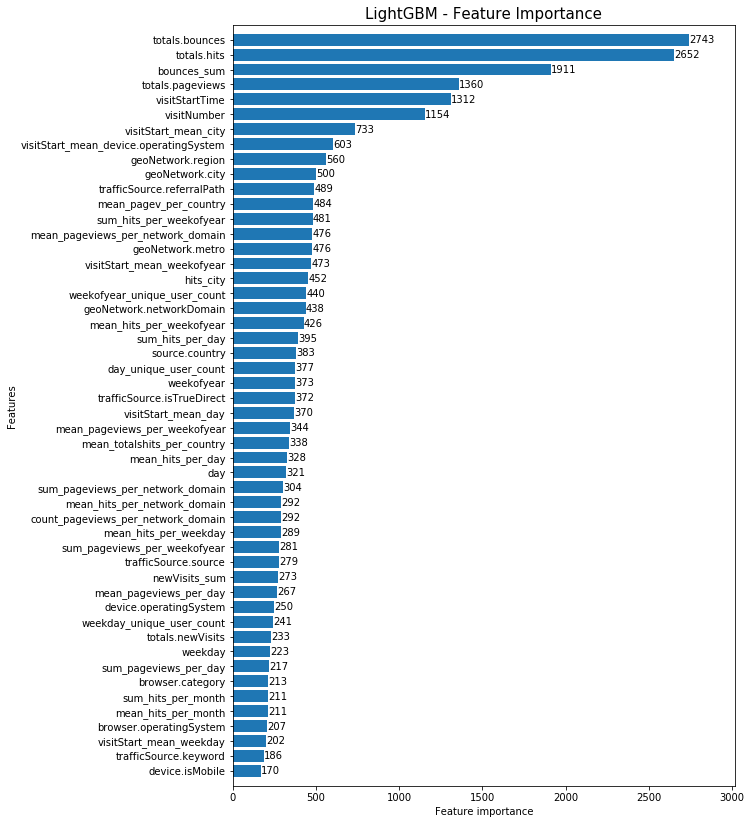

In [61]:
# Feature Importance for LGBM
fig, ax = plt.subplots(figsize=(9,14))
lgb.plot_importance(lgb_model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [62]:
# Build Results DFs
df_resultado_train = pd.DataFrame(
        {
         'y_train':y_train.astype(float),
#         'y_train_gridXGB':y_train_gridXGB,
         'y_train_lgb':y_train_lgb.astype(float),
#         'y_train_RF':y_train_RF
#         'y_train_las':y_train_las,
#         'y_train_rdg':y_train_rdg
                })

df_resultado_val = pd.DataFrame(
        {
         'y_val':y_val.astype(float),  
#         'y_val_gridXGB':y_val_gridXGB,
         'y_val_lgb':y_val_lgb.astype(float),
#         'y_val_RF':y_val_RF
#         'y_val_las':y_val_las,
#         'y_val_rdg':y_val_rdg
                })

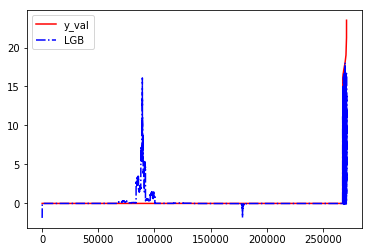

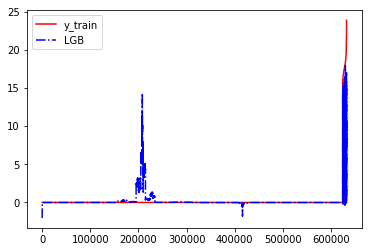

In [63]:
# Plots
import matplotlib.pyplot as plt
plt.figure(1)
df_resultado_val.sort_values('y_val_lgb',inplace=True)
df_resultado_val.sort_values('y_val',inplace=True)
plt.plot(df_resultado_val['y_val'].tolist(),'r',label='y_val')
plt.plot(df_resultado_val['y_val_lgb'].tolist(),'b-.',label='LGB')
plt.legend()

plt.figure(2)
df_resultado_train.sort_values('y_train_lgb',inplace=True)
df_resultado_train.sort_values('y_train',inplace=True)
plt.plot(df_resultado_train['y_train'].tolist(),'r-',label='y_train')
plt.plot(df_resultado_train['y_train_lgb'].tolist(),'b-.',label='LGB')
plt.legend()

In [64]:
# RMSE to evaluate the model performance
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_lgb = sqrt(mean_squared_error(y_val, y_val_lgb))
print('\n RMS lgb',rms_lgb)


 RMS lgb 1.6136233914771856
